# map2loop: Process topography, stratigraphy, fold axial traces and faults

## Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [2]:
import os
#print(os.getcwd())
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [3]:
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry

m2l_utils.v()

0.0.43


In [4]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
import geopandas as gpd
import os
from shapely.geometry import Polygon
from shapely.geometry import Point
sys.path.insert(0,"../..")
print(os.getcwd())
#rootdir=r'C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\\'
os.chdir('../')
print(os.getcwd())
os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop


## First we test to see if we have access to the online data we need
mj: We actually only need to check for the Hawiian data at the moment, but soon this will be important for other online data sources.

In [7]:
m2l_utils.have_access("oos.soest.hawaii.edu")
#have_access("services.slip.wa.gov.au")
#have_access("130.95.198.59")

available: oos.soest.hawaii.edu


## Next we define an area of interest and some other basic stuff

In [8]:
mname='hams3' #root name of model input data

model_base=-8200 # top is found using highest point in topo data

minlong=117 # should back calc from metre system
maxlong=118
minlat=-23
maxlat=-22

minx=500057    #left hams
maxx=603028    #right
miny=7455348   #bottom
maxy=7567953   #top
    

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found

src_crs = 'epsg:4326'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

# 'epsg:28350'  =  GDA_1994_MGA_Zone_50 
# 'epsg:4326'   =   wgs84 GEODETIC LAT/LONG 

orientation_decimate=0   # decimation of orientaiton data (0 = no decimation)
contact_decimate=0   # decimation of contact data (0 = no decimation)
fault_decimate=5
fold_decimate=5

gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'
ncode='NAME'
ocode='OBJECTID'
rcode='ROCKTYPE1'
tcode='TYPE'
fcode='FEATURE'
test_data_path='./test_data3/'

tmp_path=test_data_path+'tmp/'
data_path=test_data_path+'data/'
dtm_path=test_data_path+'dtm/'
output_path=test_data_path+'output/'
vtk_path=test_data_path+'vtk/'


if(not os.path.isdir(tmp_path)):
   os.mkdir(tmp_path)
if(not os.path.isdir(output_path)):
   os.mkdir(output_path)
if(not os.path.isdir(dtm_path)):
   os.mkdir(dtm_path)
if(not os.path.isdir(dtm_path)):
   os.mkdir(dtm_path)
if(not os.path.isdir(vtk_path)):
   os.mkdir(vtk_path)

strat_graph_file=test_data_path+'graph/graph_strat.gml'
#strat_graph_file=test_data_path+'graph/output/'+mname+'_strat.gml'

fault_file=data_path+'GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp'
structure_file=data_path+'hams2_structure.shp'
geology_file=data_path+'hams2_geol.shp'

dtm_file=dtm_path+mname+'_dtm.tif'
dtm_reproj_file=dtm_path+mname+'_dtm_rp.tif'



## Download and reproject the appropriate SRTM data
mj: Getting this from Hawaii, but could also get from Geoscience Australia (expect when I tried via WCS it blew up for more than 0.25 degree square areas, but I am pretty sure this is a OWS python plugin problem not GA since I can load the whole data with QGIS)

In [9]:
m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat,step_out)
geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.


-1 Fortescue_Group ----------------------
choices: 2
4 A_FOj_xs_b
0 A_FO_xo_a
6 A_FO_od
13 A_FOu_bbo
3 A_FOp_bs
12 A_FOo_bbo
5 A_FOh_xs_f
28 A_FOr_b
....
0 A_FO_xo_a
4 A_FOj_xs_b
6 A_FO_od
13 A_FOu_bbo
3 A_FOp_bs
12 A_FOo_bbo
5 A_FOh_xs_f
28 A_FOr_b

-9 Hamersley_Group ----------------------
choices: 1
10 P__HAo_ci
16 P__HAw_fr
7 P__HAj_xci_od
2 P__HAb_cib
1 A_HAu_xsl_ci
8 A_HAd_kd
9 A_HAm_cib

-12 None ----------------------
choices: 60
24 A_s_PRK
14 A_s_PMI
25 A_mgn_PRK
23 A_b_PRK
15 A_mgn_PMI
....
24 A_s_PRK
14 A_s_PMI
25 A_mgn_PRK
15 A_mgn_PMI
23 A_b_PRK
....
24 A_s_PRK
14 A_s_PMI
15 A_mgn_PMI
25 A_mgn_PRK
23 A_b_PRK
....
24 A_s_PRK
25 A_mgn_PRK
23 A_b_PRK
15 A_mgn_PMI
14 A_s_PMI
....
24 A_s_PRK
25 A_mgn_PRK
23 A_b_PRK
14 A_s_PMI
15 A_mgn_PMI
....
24 A_s_PRK
25 A_mgn_PRK
15 A_mgn_PMI
14 A_s_PMI
23 A_b_PRK
....
24 A_s_PRK
25 A_mgn_PRK
15 A_mgn_PMI
23 A_b_PRK
14 A_s_PMI
....
24 A_s_PRK
25 A_mgn_PRK
14 A_s_PMI
23 A_b_PRK
15 A_mgn_PMI
....
24 A_s_PRK
25 A_mgn_PRK
14 A_s_PMI
15 A_mgn_P

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


choices: 4
19 P__TKk_sf
22 P__TKo_stq
26 P__TKa_xs_k
11 P__TK_s
....
19 P__TKk_sf
22 P__TKo_stq
11 P__TK_s
26 P__TKa_xs_k
....
19 P__TKk_sf
11 P__TK_s
22 P__TKo_stq
26 P__TKa_xs_k
....
11 P__TK_s
19 P__TKk_sf
22 P__TKo_stq
26 P__TKa_xs_k

-27 Wyloo_Group ----------------------
choices: 2
17 P__WYm_sp
27 P__WYa_s
18 P__WYd_kd
....
27 P__WYa_s
17 P__WYm_sp
18 P__WYd_kd


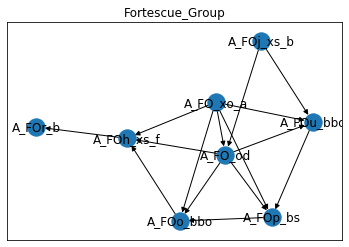

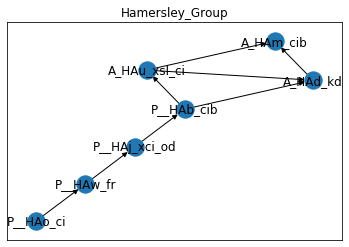

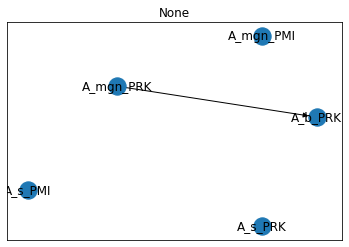

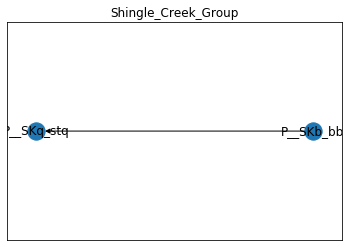

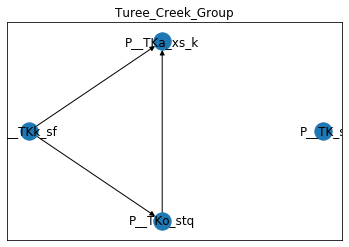

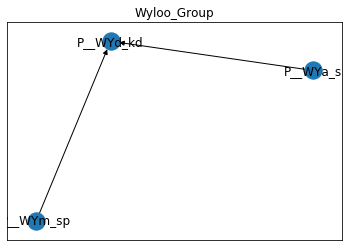

In [10]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

group choices: 1
[[-27, -21, -23, -9, -1, -12]]


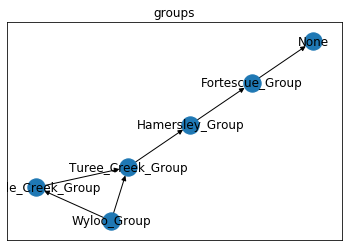

P__WYm_sp
P__WYa_s
P__WYd_kd
P__SKb_bb
P__SKq_stq
P__TKk_sf
P__TKo_stq
P__TKa_xs_k
P__TK_s
P__HAo_ci
P__HAw_fr
P__HAj_xci_od
P__HAb_cib
A_HAu_xsl_ci
A_HAd_kd
A_HAm_cib
A_FOj_xs_b
A_FO_xo_a
A_FO_od
A_FOu_bbo
A_FOp_bs
A_FOo_bbo
A_FOh_xs_f
A_FOr_b
A_s_PRK
A_s_PMI
A_mgn_PRK
A_b_PRK
A_mgn_PMI


In [11]:
m2l_topology.save_group(G,mname,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

{'init': 'epsg:28350'}


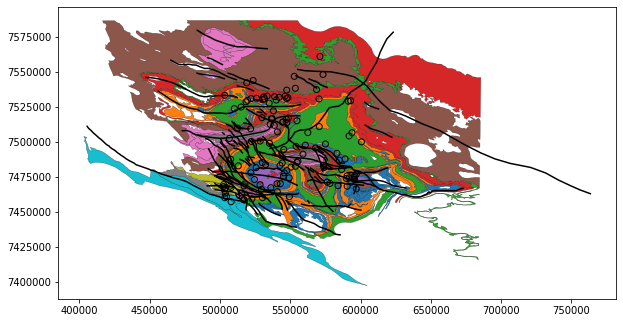

In [12]:
# Extract point data from WAROX & geology map for gempy
##First we readin the WAROX and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)
print(geology.crs)

base=geology.plot(column=ccode,figsize=(10,10),edgecolor='#000000',linewidth=0.2)

structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs

faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs

sub_pts = structure[['geometry',dcode,ddcode]]

sub_pts.plot(ax=base, color='none',edgecolor='black')
faults.plot(ax=base, color='black',edgecolor='black')

## Clip geology, faults, structures and map geology to structures

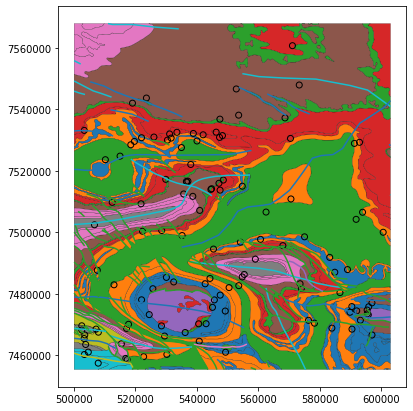

In [14]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 

geol_clip=m2l_utils.clip_shp(geology, polygo)
faults_clip=m2l_utils.clip_shp(faults,polygo)
structure_clip = m2l_utils.clip_shp(structure_code, polygo)

base = geol_clip.plot(column=ccode,figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=tcode,edgecolor='black')
structure_clip.plot(ax=base, color='none',edgecolor='black')

geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')


## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='../graphics/polarity.png'>

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [15]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_code,mname,output_path,ddcode,dcode,ccode,rcode,orientation_decimate,dtm)


## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [12]:
m2l_geometry.create_orientations(mname, tmp_path, output_path, dtm,geol_clip,structure_clip,ccode,gcode)

6 [('Wyloo_Group', 0), ('Shingle_Creek_Group', 0), ('Turee_Creek_Group', 0), ('Hamersley_Group', 0), ('Fortescue_Group', 0), ('None', 0)]
Orientations----------
 6 [('Wyloo_Group', 1), ('Shingle_Creek_Group', 1), ('Turee_Creek_Group', 1), ('Hamersley_Group', 1), ('Fortescue_Group', 1), ('None', 0)]
Contacts----------
 29 {'A-FOj-xs-b', 'P_-WYd-kd', 'P_-HAb-cib', 'P_-WYm-sp', 'A-mgn-PRK', 'A-HAd-kd', 'P_-WYa-s', 'P_-HAo-ci', 'A-HAm-cib', 'A-FOp-bs', 'A-FOr-b', 'P_-SKb-bb', 'A-s-PMI', 'A-b-PRK', 'P_-TKo-stq', 'A-s-PRK', 'P_-SKq-stq', 'A-HAu-xsl-ci', 'P_-TKa-xs-k', 'P_-TK-s', 'A-FOh-xs-f', 'P_-HAj-xci-od', 'A-mgn-PMI', 'A-FOu-bbo', 'A-FOo-bbo', 'A-FO-od', 'P_-HAw-fr', 'A-FO-xo-a', 'P_-TKk-sf'}


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.

<font color='red'>Needs also to account for case when missing surface in stratigraphy means that locally basal polyline can ALSO be anothe rthan youngest surface.</font>
<img src='../graphics/base.png'>

In [13]:
print(os.getcwd())

ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(mname,tmp_path,dtm,geol_clip,contact_decimate,ccode,gcode,ocode)


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop
decimation: 1 / 0
surfaces: 30
polygons: 186
[[1, 'P__WYm_sp'], [2, 'P__WYa_s'], [3, 'P__WYd_kd'], [4, 'P__SKb_bb'], [5, 'P__SKq_stq'], [6, 'P__TKk_sf'], [7, 'P__TKo_stq'], [8, 'P__TKa_xs_k'], [9, 'P__TK_s'], [10, 'P__HAo_ci'], [11, 'P__HAw_fr'], [12, 'P__HAj_xci_od'], [13, 'P__HAb_cib'], [14, 'A_HAu_xsl_ci'], [15, 'A_HAd_kd'], [16, 'A_HAm_cib'], [17, 'A_FOj_xs_b'], [18, 'A_FO_xo_a'], [19, 'A_FO_od'], [20, 'A_FOu_bbo'], [21, 'A_FOp_bs'], [22, 'A_FOo_bbo'], [23, 'A_FOh_xs_f'], [24, 'A_FOr_b'], [25, 'A_s_PRK'], [26, 'A_s_PMI'], [27, 'A_mgn_PRK'], [28, 'A_b_PRK'], [29, 'A_mgn_PMI']]
BoundingBox(left=500000.0000000026, bottom=7454093.693147668, right=605065.852135498, top=7567173.042479938)
allpts= 13151


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [14]:
m2l_geometry.save_basal_no_faults(mname,tmp_path+'basal_contacts2.shp',tmp_path+'faults_clip.shp',ls_dict,10,ccode,gcode,dst_crs)

(283,)


## Remove faults from decimated basal contacts as save as csv file

In [15]:
m2l_geometry.save_contacts_with_faults_removed(mname,tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,ccode,dst_crs,dtm)

283
decimated points: 283


## Save fault as contact info and and orientation info make vertical (for the moment)

In [16]:
m2l_geometry.save_faults(mname,tmp_path+'faults_clip.shp',output_path,dtm,ncode,ocode,fault_decimate)

## Create basal contact points with orientation from orientations and basal points

In [17]:
contacts = gpd.read_file(tmp_path+'basal_contacts2.shp') #load orientation data as geopandas dataframe 
structures = gpd.read_file(tmp_path+'structure_clip.shp') #load orientation data as geopandas dataframe 

m2l_geometry.create_basal_contact_orientations(mname,contacts,structures,output_path,dtm,2500,ccode,gcode,dcode,ddcode)


In [18]:
m2l_geometry.save_faults(mname,tmp_path+'faults_clip.shp',output_path,dtm,ncode,ocode,fault_decimate)

## Creates fold axial trace points

In [19]:
m2l_geometry.save_fold_axial_traces(mname,tmp_path+'faults_clip.shp',output_path,dtm,ocode,tcode,fcode,fold_decimate)